In [1]:
# imports 
# data science tools 
import pandas as pd
import numpy as np

#modeling tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier # will need to use Tfidf for this 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
# tree based shit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from IPython.display import Image

#plotting tools
import pydotplus
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
ds = pd.read_csv('/Users/katychow/DSI/Projects/project-3/Data/Reddit_MH_201812160842.csv')

In [3]:
# ds.head()

In [3]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
porter = nltk.stem.PorterStemmer()

In [4]:
def stemme(my_example_string):
    my_example_list = []

    for each in my_example_string.split():
        my_example_list.append(porter.stem(each))

    return ' '.join(my_example_list)

In [5]:
def lemma_lemma(my_example_string):
    my_example_list = []

    for each in my_example_string.split():
        my_example_list.append(lemmatizer.lemmatize(each))

    return ' '.join(my_example_list)

In [6]:
ds['text_lemmatized'] = ds.title.apply(lemma_lemma)
ds['text_stemmed']=ds.title.apply(stemme)

In [7]:
ds.head()

,downs,likes,num_comments,score,subreddit,time_of_pull,title,ups,url,view_count,text_lemmatized,text_stemmed
0,0,NaN,0,1,mentalhealth,2018-12-16 08:20:31.781459,Why am I afraid to express myself?,1,https://www.reddit.com/r/mentalhealth/comments...,NaN,Why am I afraid to express myself?,whi am I afraid to express myself?
1,0,NaN,22,204,mentalhealth,2018-12-16 08:20:31.781468,"I was talked out of an abortion at 18, now I'm...",204,https://www.reddit.com/r/mentalhealth/comments...,NaN,"I wa talked out of an abortion at 18, now I'm ...","I wa talk out of an abort at 18, now i'm 22 an..."
2,0,NaN,0,7,mentalhealth,2018-12-16 08:20:31.781471,We will be dead in less than 110 years so the ...,7,https://www.reddit.com/r/mentalhealth/comments...,NaN,We will be dead in le than 110 year so the pai...,We will be dead in less than 110 year so the p...
3,0,NaN,4,2,mentalhealth,2018-12-16 08:20:31.781473,"Everything is falling apart, I wish someone wo...",2,https://www.reddit.com/r/mentalhealth/comments...,NaN,"Everything is falling apart, I wish someone wo...","everyth is fall apart, I wish someon would und..."
4,0,NaN,10,117,mentalhealth,2018-12-16 08:20:31.781475,I'm finally happy again,117,https://www.reddit.com/r/mentalhealth/comments...,NaN,I'm finally happy again,i'm final happi again


In [8]:
X = ds['text_stemmed']
y = ds['ups'].map(lambda x: 15 if x>= 15 else x)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [9]:
cv = CountVectorizer(stop_words='english',ngram_range=(1,1))
cv.fit(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

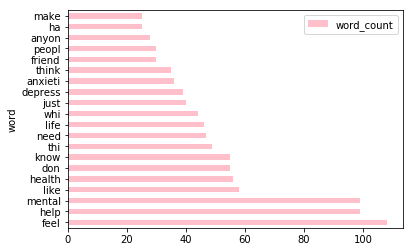

In [10]:
data_cv = cv.transform(ds['text_stemmed'])
sum_words = data_cv.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in     cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
pd.DataFrame(words_freq,columns=['word','word_count']).head(20)
pd.DataFrame(words_freq,columns=['word','word_count']).head(20).plot.barh(x='word', y='word_count',color='pink')

In [11]:
# mn_lr = LogisticRegressionCV(multi_class='multinomial', solver='newton-cg')
# mn_lr.fit(X_train_cv,y_train)
# mn_lr.score(X_train_cv,y_train), mn_lr.score(X_test_cv,y_test)

In [12]:
y.value_counts(normalize = True)

2     0.318826
3     0.174089
1     0.164980
4     0.071862
5     0.055668
15    0.052632
0     0.042510
6     0.034413
7     0.024291
8     0.019231
9     0.012146
10    0.010121
14    0.006073
11    0.006073
13    0.004049
12    0.003036
Name: ups, dtype: float64

In [14]:
# baseline is 0.32

### trying random forest with grid search here

In [13]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators':[1,3,5,10,15]
    ,'criterion':['gini','entropy']
    ,'max_depth':[None,3,5]
    ,'max_leaf_nodes':[None,3,5,7,9]
}
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf.fit(X_train_cv,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 3, 5, 10, 15], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 3, 5], 'max_leaf_nodes': [None, 3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [14]:
print(gs_rf.best_score_)
gs_rf.best_params_

0.3252361673414305


{'criterion': 'entropy',
 'max_depth': 3,
 'max_leaf_nodes': 5,
 'n_estimators': 5}

In [15]:
gs_rf.score(X_train_cv,y_train), gs_rf.score(X_test_cv,y_test)

(0.32118758434547906, 0.32388663967611336)

### trying gradient or adaboosting here... 

In [16]:
ada = AdaBoostClassifier()
ada_params = {
    'n_estimators' :[50,100]
    ,'base_estimator': [LogisticRegression(),DecisionTreeClassifier(max_depth=1)]
    ,'learning_rate': [1,1.5,0.5]
}
gs_ada = GridSearchCV(ada,param_grid=ada_params,cv=5)
gs_ada.fit(X_train_cv,y_train)
print(gs_ada.best_score_) #best score is already crossvalidated bc we set cv
print(gs_ada.best_params_)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


0.32118758434547906
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'learning_rate': 0.5, 'n_estimators': 50}


In [17]:
gs_ada.score(X_train_cv,y_train), gs_ada.score(X_test_cv,y_test)

(0.33063427800269907, 0.31983805668016196)

In [21]:
gb = GradientBoostingClassifier()
gb_params = {
    'n_estimators':[10,50,100]
    ,'learning_rate':[0.1,0.5,1]
    ,'max_leaf_nodes':[None,3,5,10]
    ,'max_depth':[3,5,7]
}
gs_gb = GridSearchCV(gb, param_grid=gb_params, cv = 5)
gs_gb.fit(X_train_cv,y_train)
print(gs_gb.best_score_)
gs_gb.best_params_

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


0.29284750337381915


{'learning_rate': 0.1, 'max_depth': 7, 'max_leaf_nodes': 3, 'n_estimators': 10}

In [22]:
gs_gb.score(X_train_cv,y_train), gs_gb.score(X_test_cv,y_test)

(0.5371120107962213, 0.27530364372469635)

In [20]:
# do we want to try SVM??? -- Yes
from sklearn import svm

svc = svm.SVC()
svc_params = {
    'C': [1.0,0.5,1.5,2.0]
    ,'kernel': ['rbf','linear','sigmoid']
    ,'gamma': [0.0001,0.001,0.01]
}
gs_svc = GridSearchCV(svc, param_grid=svc_params)


gs_svc.fit(X_train_cv, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1.0, 0.5, 1.5, 2.0], 'kernel': ['rbf', 'linear', 'sigmoid'], 'gamma': [0.0001, 0.001, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [21]:
gs_svc.best_params_

{'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}

In [22]:
gs_svc.best_score_

0.31713900134952766

In [23]:
svc = svm.SVC()
svc.fit(X_train_cv,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
svc.score(X_train_cv,y_train), svc.score(X_test_cv,y_test)

(0.31713900134952766, 0.32388663967611336)

### you will notice that the ups are ~ poisson with very long tails . perhaps a better fit would be to use poisson

```python
ds.ups.mean()
ds.ups.median()
ds.ups.std()

sns.distplot(ds[ds['ups']<20].ups,bins=20,color = 'pink')

np.asarray(X_train_cv)

import statsmodels.api as sm

results = sm.GLM(y_train,
                 X_train_cv.todense(),
                 family=sm.families.Poisson(link = sm.families.links.log)).fit()

results.summary()
```
* this did not work as expected.  very little words were significant if any.  need different way to quantify ups.